In [ ]:
!pip install wordcloud

In [1]:
!pip install --upgrade transformers jax jaxlib




























   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 5.7 MB/s eta 0:00:00


  Attempting uninstall: jaxlib

    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89

    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:

      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89

  Attempting uninstall: jax

    Found existing installation: jax 0.4.26

    Uninstalling jax-0.4.26:

      Successfully uninstalled jax-0.4.26



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

from wordcloud import WordCloud
import nltk

from nltk.corpus import stopwords
import string
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset

from tqdm.notebook import tqdm

from transformers import BertTokenizer
from datasets import load_metric

In [2]:
# библиотека для очистки текста от не лишних, не имеющих смысла слов.
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# чтение датасета в переменную для дальнейшей работы с ним
dt = pd.read_csv('/kaggle/input/train-res/TRAIN_RES_3.csv')
dt.head(5)

,achievements,achievements_modified,company_name,demands,id_cv,job_title
0,NaN,NaN,"ООО ""Левита"" (отель Дерябинъ)",Встреча гостей. Оформление прибывших гостей в ...,e2505860-a5c8-11ea-833f-f3e0740405b3,администратор
1,NaN,NaN,"ООО УК ""Парус""",Консультирование жильцов МКД по общим вопросам...,e2505860-a5c8-11ea-833f-f3e0740405b3,администратор
2,NaN,NaN,"ООО ""ДЕЙВОН Спринг энд Сит""",- Контроль импортных закупок - Работа с докуме...,e2505860-a5c8-11ea-833f-f3e0740405b3,специалист
3,NaN,NaN,ООО Трия,"Консультация по ассортименту мебели, составлен...",47a6f930-9449-11ea-ac9a-69632329477c,менеджер
4,NaN,NaN,АО ОТП банк,Консультирование | Оформление | Отчётность|,0914d890-9543-11ea-b89e-1fdc17069750,эксперт


## EDA

Все столбцы в датасете состоят из обьектов тип string

In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 200000 entries, 0 to 199999

Data columns (total 6 columns):

 #   Column                 Non-Null Count   Dtype 

---  ------                 --------------   ----- 

 0   achievements           37618 non-null   object

 1   achievements_modified  37618 non-null   object

 2   company_name           199952 non-null  object

 3   demands                199058 non-null  object

 4   id_cv                  200000 non-null  object

 5   job_title              200000 non-null  object

dtypes: object(6)

memory usage: 9.2+ MB


В датасете присутсвует множество повторяющихся описаний резюме и компани, помимо этого отсутствует у большинства резюме поле достижения пропущено, что говорит о том, что основной упор при классификации будет сделан на компанию и на описание работы

In [ ]:
dt.describe()

,achievements,achievements_modified,company_name,demands,id_cv,job_title
count,37618,37618,199952,199058,200000,200000
unique,26875,26861,130444,147245,89955,965
top,успешное выполнение своих обязанностей,нет,ПАО Сбербанк,Согласно должностной инструкции,fc7187c0-a5e6-11e8-b833-ef76bd2a03c1,специалист
freq,154,157,641,221,27,22143


In [ ]:
print("\nКоличество уникальных значений в каждом столбце:")
for col in dt.columns:
    print(f"{col}: {dt[col].nunique()}")



Количество уникальных значений в каждом столбце:

achievements: 26875

achievements_modified: 26861

company_name: 130444

demands: 147245

id_cv: 89955

job_title: 965


In [ ]:
missing_values = dt.isnull().sum()
print("\nПропущенные значения в данных:")
print(missing_values)



Пропущенные значения в данных:

achievements             162382

achievements_modified    162382

company_name                 48

demands                     942

id_cv                         0

job_title                     0

dtype: int64


В датасете присутсвует сильный дисбаланс классов, из за которого некотрые классы встречаются всего один раз, так что для классификации просто напросто невозможно использовать классические алгоритмы, в которых нет zero-shot learning, который позволит моделе по своиму предыдущему опыту определить к какой вакансии относится описание резюме. 



Распределение значений для job_title:

job_title

специалист                          51767

инженер                             31836

бухгалтер                           31183

менеджер                            30103

оператор                            19804

                                    ...  

драгер                                  1

заправщик поливомоечных машин           1

паркетчик                               1

составитель химических растворов        1

давильщик                               1

Name: count, Length: 1243, dtype: int64


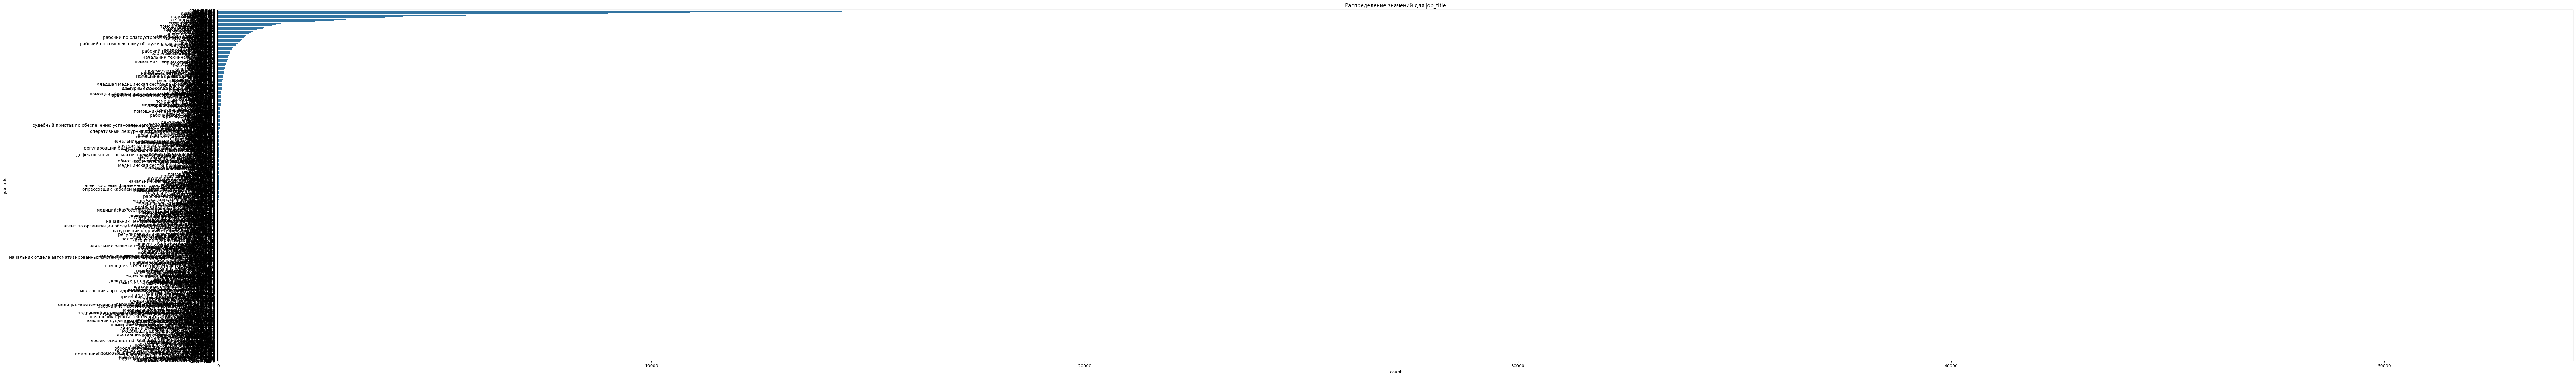



Распределение значений для company_name:

company_name

ПАО Сбербанк                                                                                                      1574

ИП                                                                                                                 795

ОАО РЖД                                                                                                            704

Почта России                                                                                                       649

ФГУП Почта России                                                                                                  595

                                                                                                                  ... 

Муниципальное бюджетное общеобразовательное учреждение "Начальная общеобразовательная школа №95" г. Челябинска       1

ООО Книжный клуб "Клуб семейного досуга"                                                              

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ae3d596b1c0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ae3d596a440> (for post_execute):


KeyboardInterrupt: 

In [ ]:
categorical_columns = ['job_title', 'company_name']
for col in categorical_columns:
    print(f"\nРаспределение значений для {col}:")
    print(dt[col].value_counts())
    plt.figure(figsize=(40, 25))
    sns.countplot(y=dt[col], order=dt[col].value_counts().index)
    plt.title(f'Распределение значений для {col}')
    plt.show()

Большинство описаний достижений имеют короткую длинну из чего можно сделать вывод, что они мало информативны и даже при их присутсвии из них модель сможет подчерпнуть лишь какую то маленькую часть информации.

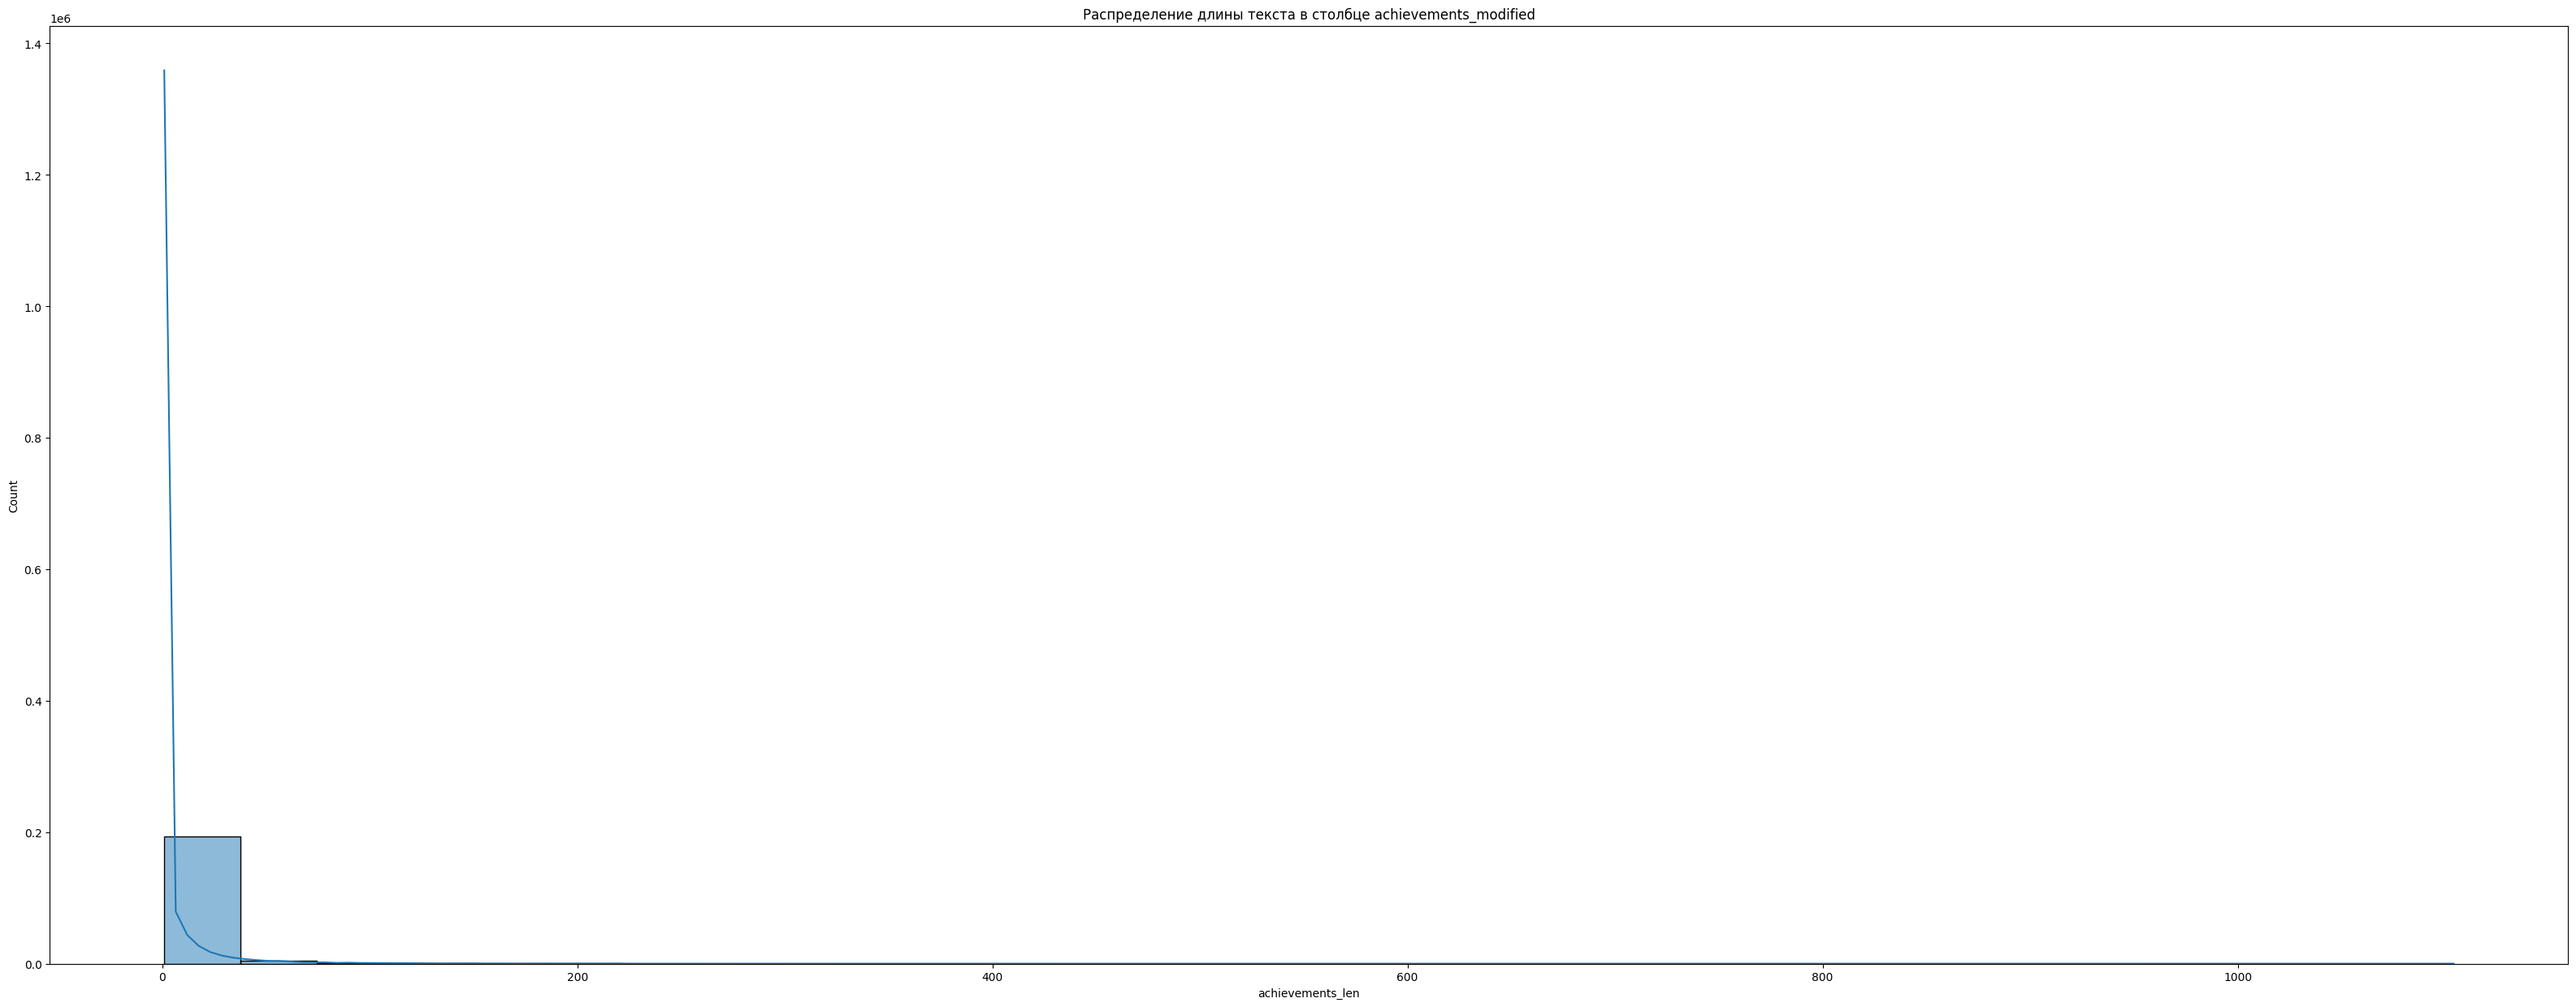

In [ ]:
dt['achievements_len'] = dt['achievements_modified'].apply(lambda x: len(str(x).split()))
dt['demands_len'] = dt['demands'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(40, 15))
sns.histplot(dt['achievements_len'], bins=30, kde=True)
plt.title('Распределение длины текста в столбце achievements_modified')
plt.show()

Описание предыдущей работы бывают, как короткими так и достаточно длинными, что говорит, что это будет основной фичей, которая будет иметь наибольшее значение в выборе модели. Также в этом столце находится информация об опыте сотрудника, что подтверждает, что определение его вакансии моделью в большей мере будет зависеть от информации в этом столбце.

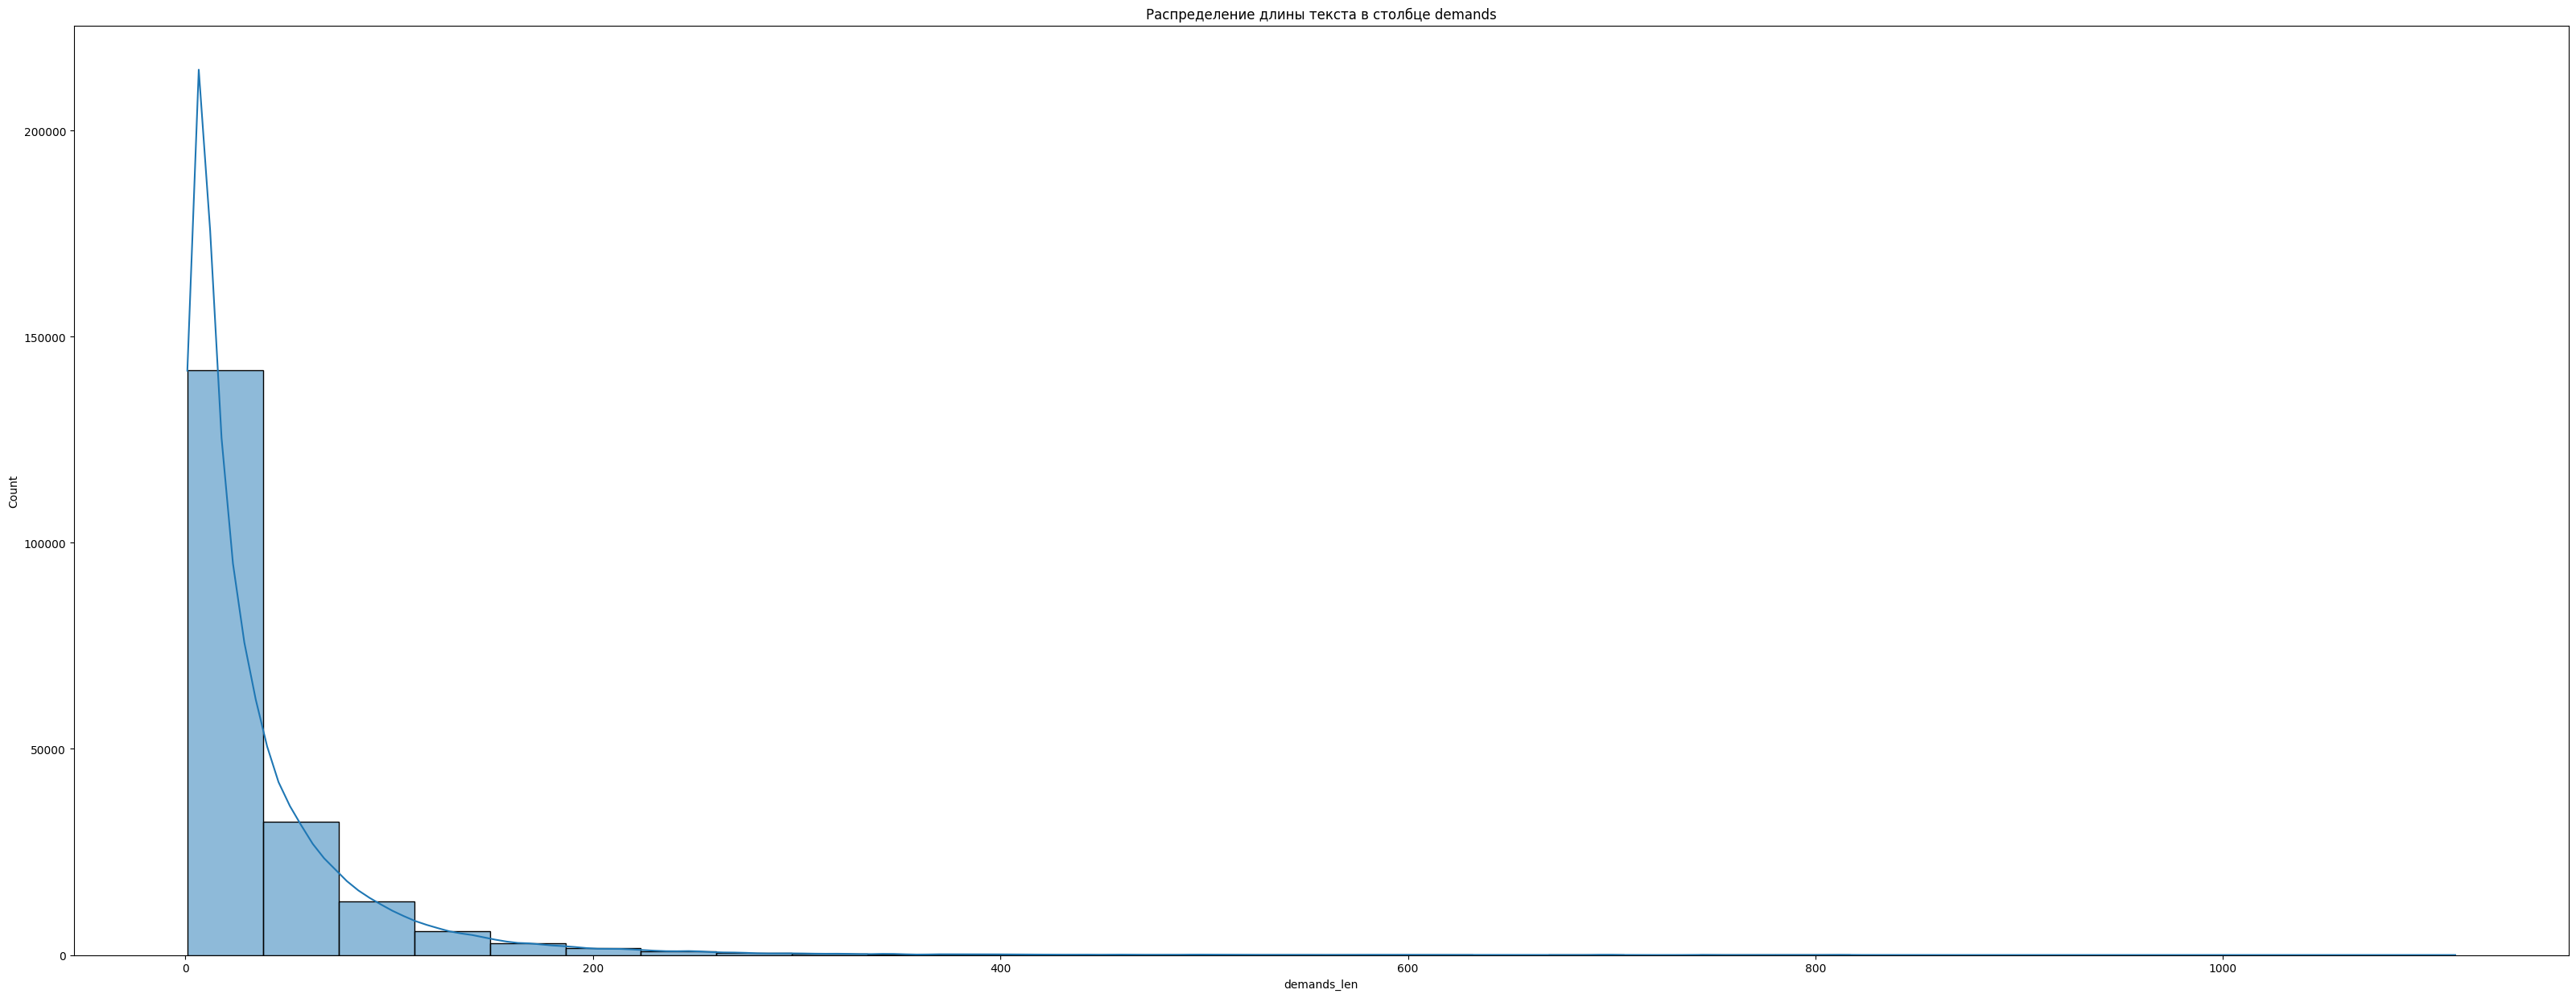

In [ ]:
plt.figure(figsize=(40, 15))
sns.histplot(dt['demands_len'], bins=30, kde=True)
plt.title('Распределение длины текста в столбце demands')
plt.show()

По данному графику видно, что одиними из самых популярных фраз являются: "заключение договоров", "консультирование клиентов", "организация работы", что сходится с тем фактом, что самым популярным классом является специалист, менеджер и бухгалтер. 

In [ ]:
all_text = ' '.join(dt['demands'].dropna().astype(str).tolist())

# Очистим текст от пунктуации и стоп-слов
all_text = all_text.lower().translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации
all_text = ' '.join([word for word in all_text.split() if word not in russian_stopwords])  # Удаление стоп-слов

# Создадим объект WordCloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_text)

# Построим график облака слов
plt.figure(figsize=(40, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для столбца demands')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## solution with ruBERT-tiny2

Мы решили взять данную модель, так как данная модель является надежной, проверенной временем, также в ней присутствует zero-shot learning, она предобучена на русском языке, с которым нам предстоит работать, а также она легка в использовании в задачах классификации и отлично для них подходит. 

LLM здесь не подходит, так как простая LLM из коробки не так хорошо осведомлена о специфике вакансий, что будет допускать большое количество ошибок, также для нее будет необходимо выделять мощности для ее инференса, более большие LLm, которые смогут без дообучения классифицировать тексты придется инференсить на очень мощных и дорогих серверах. Дообучать LLm в рамках средней компании, просто напросто является невозможным из за цены и в нашем случае тоже, потому что всего 3 дня и нет необходимых мощностей. Попытаться обьяснить промптом LLm подобную задачу просто напросто забьет ей весь контекст различными терминами, в которых она в конечном итоге запутается, елси же использовать langchain и векторную базу данных, то ее все ранво придется пополнять и следить за ней а также выделять под это дополнительные ресурсы, что ничем не выгоднее чем просто дообучать ruBERT.

В этой задаче использовать знаменитый XGboost или catboost не является возомжным, так как не достаточно данных для обучения на каждом из классов, из за чего алгоритм просто теряет всю свою силу.

### Data preprocessing

In [4]:
# Выделяем столбцы с фичами, которые нужно обьединить в целостный текст для ruBERT и столбец с таргет знаечниями, которые надо перевести в индексы
target_column = 'job_title'  # Столбец с названиями должностей
text_columns = ['achievements_modified', 'demands', 'company_name']  # Текстовые столбцы

In [5]:
# Преобразуем должности в индексы и проверяем количество уникальных должностей в датасете
dt['text'] = dt[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt['label'] = pd.factorize(dt[target_column])[0]  # Преобразуем должности в цифры
num_labels = len(dt['label'].unique())  # Количество уникальных классов
num_labels

1561

In [6]:
# Создаем переменную для cuda, чтобы удобнее переводить модель на gpu ускорители
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# Загружаем предобученный на русском токенизатор с hugging face для создания ембедингов
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# Загружаем предобученную на русском модель ruBERT для классификации
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=num_labels)
model.to(device)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [9]:
# Создаем класс для датасета, где сразу же переводим все тексты и лейблы на девайс для более быстрой работы алгоритма обучения
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.labels = self.labels.reset_index(drop=True) # сбрасываем индексы, чтобы в дальнейшем с ними не было пробелм при обучении
        assert len(self.labels) == len(self.encodings['input_ids']), "Метки и данные имеют разную длину" # Делаем проверку на то, правильно ли установлены все индексы
    # метод для получения длинны датасета
    def __len__(self):
        return len(self.labels)

    # Метод для получения элемента по индексу
    def __getitem__(self, idx):
        # Проверим наличие индексов
        assert idx < len(self.labels), f"Индекс {idx} вне диапазона!"
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(device)
        return item

In [10]:
# Функция для запуска обучения
def training_model():
    metric_f1 = load_metric("f1")
    
    # Функция вычисления метрики f1_score
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        # Рассчитываем F1-score
        f1 = metric_f1.compute(predictions=predictions, references=labels, average="weighted")

        return {"f1": f1["f1"]}

    # Настройка обучения
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir='./logs',
    )
    
    # настраиваем основные параметры trainer для запуска обучения нужной модели на нужных данных
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics  # Передаем функцию вычисления метрик
    )

    # Обучение модели
    trainer.train()

In [11]:
idx = 0
chunk_size = 200000
print(f"Training on chunk: {idx} to {min(idx + chunk_size, len(dt))}")

# Извлекаем часть датасета
dt_small = dt[idx: idx + chunk_size].copy()
dt_small['text'] = dt_small[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt_small['label'] = pd.factorize(dt_small[target_column])[0]  # Преобразуем метки

# Сплит на тренировочные и валидационные данные
train_texts, val_texts, train_labels, val_labels = train_test_split(dt_small['text'], dt_small['label'], test_size=0.2, random_state=42)

# Сбрасываем индексацию
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

print("Data tokenized successfully")
print(' ')

# Создаем датасеты для тренировки и валидации
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Даталоадеры
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

# Проверка на совпадение количества токенов и меток
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

# Обучаем модель на текущем куске
training_model()

# Увеличиваем индекс для следующего куска
idx += chunk_size


Training on chunk: 0 to 200000
Data tokenized successfully
 


/tmp/ipykernel_36/3068549824.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_f1 = load_metric("f1")


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,3.246100,3.149128,0.238786
2,2.672400,2.641544,0.345425
3,2.409600,2.438706,0.372036
4,2.298500,2.349822,0.389991
5,2.263500,2.323727,0.398071


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [12]:
idx = 200000
chunk_size = 200000
print(f"Training on chunk: {idx} to {min(idx + chunk_size, len(dt))}")

# Извлекаем часть датасета
dt_small = dt[idx: idx + chunk_size].copy()
dt_small['text'] = dt_small[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt_small['label'] = pd.factorize(dt_small[target_column])[0]  # Преобразуем метки

# Сплит на тренировочные и валидационные данные
train_texts, val_texts, train_labels, val_labels = train_test_split(dt_small['text'], dt_small['label'], test_size=0.2, random_state=42)

# Сбрасываем индексацию
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

print("Data tokenized successfully")
print(' ')

# Создаем датасеты для тренировки и валидации
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Даталоадеры
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

# Проверка на совпадение количества токенов и меток
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

# Обучаем модель на текущем куске
training_model()

# Увеличиваем индекс для следующего куска
idx += chunk_size

Training on chunk: 200000 to 400000
Data tokenized successfully
 


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,2.671300,2.585734,0.381222
2,2.357700,2.326133,0.419687
3,2.175400,2.209202,0.444269
4,2.094500,2.160110,0.455686
5,2.020400,2.144481,0.459531


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [13]:
idx = 400000
chunk_size = 200000
print(f"Training on chunk: {idx} to {min(idx + chunk_size, len(dt))}")

# Извлекаем часть датасета
dt_small = dt[idx: idx + chunk_size].copy()
dt_small['text'] = dt_small[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt_small['label'] = pd.factorize(dt_small[target_column])[0]  # Преобразуем метки

# Сплит на тренировочные и валидационные данные
train_texts, val_texts, train_labels, val_labels = train_test_split(dt_small['text'], dt_small['label'], test_size=0.2, random_state=42)

# Сбрасываем индексацию
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

print("Data tokenized successfully")
print(' ')

# Создаем датасеты для тренировки и валидации
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Даталоадеры
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

# Проверка на совпадение количества токенов и меток
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

# Обучаем модель на текущем куске
training_model()

# Увеличиваем индекс для следующего куска
idx += chunk_size

Training on chunk: 400000 to 600000
Data tokenized successfully
 


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,2.562200,2.479447,0.415057
2,2.251600,2.253610,0.452688
3,2.104900,2.153217,0.471507
4,2.048500,2.109480,0.482298
5,1.964700,2.095915,0.484307


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [15]:
# Сохранение модели
model.save_pretrained('./rubert-model')

# Сохранение токенизатора
tokenizer.save_pretrained('./rubert-model')

('./rubert-model/tokenizer_config.json',
 './rubert-model/special_tokens_map.json',
 './rubert-model/vocab.txt',
 './rubert-model/added_tokens.json',
 './rubert-model/tokenizer.json')

In [24]:
idx = 600000
chunk_size = 200000
print(f"Training on chunk: {idx} to {min(idx + chunk_size, len(dt))}")

# Извлекаем часть датасета
dt_small = dt[idx: idx + chunk_size].copy()
dt_small['text'] = dt_small[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt_small['label'] = pd.factorize(dt_small[target_column])[0]  # Преобразуем метки

# Сплит на тренировочные и валидационные данные
train_texts, val_texts, train_labels, val_labels = train_test_split(dt_small['text'], dt_small['label'], test_size=0.2, random_state=42)

# Сбрасываем индексацию
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

print("Data tokenized successfully")
print(' ')

# Создаем датасеты для тренировки и валидации
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Даталоадеры
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

# Проверка на совпадение количества токенов и меток
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

# Обучаем модель на текущем куске
training_model()

# Увеличиваем индекс для следующего куска
idx += chunk_size

Training on chunk: 600000 to 800000
Data tokenized successfully
 


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,2.160300,2.156240,0.481765
2,1.989500,2.050342,0.497860
3,1.868800,2.004041,0.508294
4,1.771100,1.987222,0.514282
5,1.752700,1.979818,0.515705


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [25]:
idx = 800000
chunk_size = 200000
print(f"Training on chunk: {idx} to {min(idx + chunk_size, len(dt))}")

# Извлекаем часть датасета
dt_small = dt[idx: idx + chunk_size].copy()
dt_small['text'] = dt_small[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt_small['label'] = pd.factorize(dt_small[target_column])[0]  # Преобразуем метки

# Сплит на тренировочные и валидационные данные
train_texts, val_texts, train_labels, val_labels = train_test_split(dt_small['text'], dt_small['label'], test_size=0.2, random_state=42)

# Сбрасываем индексацию
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

print("Data tokenized successfully")
print(' ')

# Создаем датасеты для тренировки и валидации
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Даталоадеры
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

# Проверка на совпадение количества токенов и меток
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

# Обучаем модель на текущем куске
training_model()

# Увеличиваем индекс для следующего куска
idx += chunk_size

Training on chunk: 800000 to 1000000
Data tokenized successfully
 


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,2.462900,2.352689,0.455160
2,2.147700,2.140450,0.491570
3,1.967500,2.053936,0.508250
4,1.903800,2.014308,0.514473
5,1.837700,2.002317,0.518196


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [ ]:
idx = 1000000
chunk_size = 200000
print(f"Training on chunk: {idx} to {min(idx + chunk_size, len(dt))}")

# Извлекаем часть датасета
dt_small = dt[idx: idx + chunk_size].copy()
dt_small['text'] = dt_small[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt_small['label'] = pd.factorize(dt_small[target_column])[0]  # Преобразуем метки

# Сплит на тренировочные и валидационные данные
train_texts, val_texts, train_labels, val_labels = train_test_split(dt_small['text'], dt_small['label'], test_size=0.2, random_state=42)

# Сбрасываем индексацию
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

print("Data tokenized successfully")
print(' ')

# Создаем датасеты для тренировки и валидации
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Даталоадеры
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

# Проверка на совпадение количества токенов и меток
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

# Обучаем модель на текущем куске
training_model()

# Увеличиваем индекс для следующего куска
idx += chunk_size

Training on chunk: 1000000 to 1200000


In [ ]:
idx = 1200000
chunk_size = 200000
print(f"Training on chunk: {idx} to {min(idx + chunk_size, len(dt))}")

# Извлекаем часть датасета
dt_small = dt[idx: idx + chunk_size].copy()
dt_small['text'] = dt_small[text_columns].fillna('').apply(lambda x: '. '.join(x), axis=1)
dt_small['label'] = pd.factorize(dt_small[target_column])[0]  # Преобразуем метки

# Сплит на тренировочные и валидационные данные
train_texts, val_texts, train_labels, val_labels = train_test_split(dt_small['text'], dt_small['label'], test_size=0.2, random_state=42)

# Сбрасываем индексацию
train_texts = train_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Токенизация
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

print("Data tokenized successfully")
print(' ')

# Создаем датасеты для тренировки и валидации
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Даталоадеры
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)

# Проверка на совпадение количества токенов и меток
assert len(train_encodings['input_ids']) == len(train_labels), "Количество токенов не совпадает с количеством меток!"

# Обучаем модель на текущем куске
training_model()

# Увеличиваем индекс для следующего куска
idx += chunk_size

In [ ]:
model.eval()

all_preds = []
all_labels = []

# Проходим по валидационным данным
with torch.no_grad():
    for batch in tqdm(val_loader):
        # Загружаем данные на устройство (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Получаем предсказания
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Преобразуем логиты в предсказанные метки
        preds = torch.argmax(logits, dim=-1)

        # Собираем все предсказания и реальные метки для последующей оценки
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Вычисляем F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1-score: {f1}")

In [1]:
# Сохранение модели
model.save_pretrained('./rubert-model')

# Сохранение токенизатора
tokenizer.save_pretrained('./rubert-model')

NameError: name 'model' is not defined